In [39]:
import numpy as np 
from scipy.optimize import minimize 
from scipy import linalg 
import matplotlib.pyplot as plt
import random
%matplotlib inline

# np.random.seed(0) 
N = 100 
half_n = N//2 
r = 10 
s = r/16 
t = np.random.uniform(0, 2*np.pi, half_n) 
n = s*np.random.randn(half_n) 
x1 , y1 = (r + n)*np.cos(t), (r + n)*np.sin(t) 
X_circ = np.hstack((x1.reshape(half_n, 1) , y1.reshape(half_n , 1))) 

m, b = -1, 2 
x2 = np.linspace(-12, 12 , half_n) 
y2 = m*x2 + b + s*np.random.randn(half_n) 
X_line = np.hstack((x2.reshape(half_n , 1) , y2.reshape(half_n , 1))) 
X = np.vstack((X_circ , X_line))
y=y1 + y2


In [40]:
class RANSAC:
    def __init__(self,x_data,y_data,min_samples,dis_thres,num_samps):
        self.x_data=x_data
        self.y_data=y_data
        self.s=min_samples
        self.t=dis_thres
        self.N=num_samps
        self.best_model=None
        self.inliers=[]
        self.outliers=[]
        self.points=[]

    def distance(self,p1,p2):
        return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5

    def random_sample(self):
        self.points=[]
        i=0
        while i<self.s:
            ind=random.randint(0,len(self.x_data)-1)
            pnt=(self.x_data[ind],self.y_data[ind])
            if pnt not in self.points:
                self.points.append(pnt)
                i+=1

    def circle_equation(self):
        pt1,pt2,pt3=self.points
        Y = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        Z = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])
        inverse_Y = linalg.inv(Y)
        c_x, c_y = np.dot(inverse_Y, Z) / 2
        cx, cy = c_x[0], c_y[0]
        r = np.sqrt((cx - pt1[0])**2 + (cy - pt1[1])**2)
        return cx, cy, r

    def inliers_filter(self):
        new_inliers=[]
        new_outliers=[]
        xc,yc,r=self.circle_equation()
        for i in range(len(self.x_data)):
            dist=self.distance((self.x_data[i],self.y_data[i]),(xc,yc))
            if abs(dist-r)<=self.t:
                new_inliers.append((self.x_data[i],self.y_data[i]))
            else:
                new_outliers.append((self.x_data[i],self.y_data[i]))
            
        if len(self.inliers)<len(new_inliers):
            self.inliers=new_inliers
            self.outliers=new_outliers
            self.best_model=(xc,yc,r)

    def model_finder(self):
        for i in range(self.N):
            self.random_sample()
            self.inliers_filter()

        return self.best_model
    
    

In [41]:
best_samp=RANSAC(X[:,0],X[:,1],3,1,35)
best_samp.model_finder()

(61.83260424360861, 60.74022793380389, 85.33113108856404)

In [31]:
ransac=RANSAC(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],3,1,35)
ransac.model_finder()

(-0.461205997669277, -0.8892248868298338, 10.070882812721054)

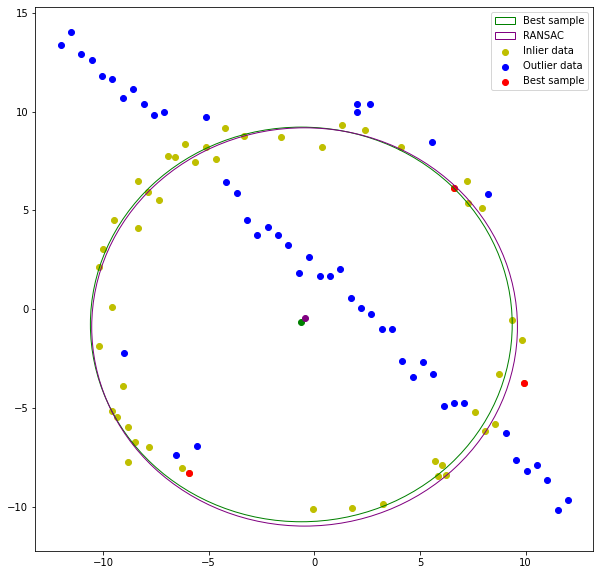

In [32]:
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],c='y',label='Inlier data')
ax.scatter(np.array(best_samp.outliers)[:,0],np.array(best_samp.outliers)[:,1],c='b',label='Outlier data')

circle1 = plt.Circle((best_samp.best_model[0], best_samp.best_model[1]), best_samp.best_model[2], color='green',fill=False,label='Best sample')
ax.add_patch(circle1)

circle2 = plt.Circle((ransac.best_model[0], ransac.best_model[1]), ransac.best_model[2], color='purple',fill=False,label='RANSAC')
ax.add_patch(circle2)

ax.scatter(np.array(best_samp.points)[:,0],np.array(best_samp.points)[:,1],c='r',label='Best sample')
ax.scatter(best_samp.best_model[0],best_samp.best_model[0],c='green')
ax.scatter(ransac.best_model[0],ransac.best_model[0],c='purple')
ax.legend(loc='upper right')
plt.show()

In [44]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

dst_points=[]
def get_coord(img_name):
    global dst_points
    img=cv.imread(img_name)
    count=0
    def click_event(event, x, y, flags, params):
        if event==cv.EVENT_LBUTTONDOWN:
            dst_points.append([x,y])
            cv.circle(img, (x,y), 2, [0,0,255], 2)
            cv.imshow('image', img)
        
    cv.namedWindow('image',cv.WINDOW_AUTOSIZE)    
    cv.imshow('image', img)
    cv.setMouseCallback('image', click_event)
    while count<4:
        cv.waitKey(1) 
        count+=1
        
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    return dst_points

def homography(img_fg,img_bg):
    fh,fg=img_fg.shape[0],img_fg.shape[1]
    pts_src = np.array([[0, 0], [0, fg], [fh, 0],[fh, fg]])
    pts_dst = np.array(get_coord('hall.jpg'))

    h, status = cv.findHomography(pts_src, pts_dst)
    im_out = cv.warpPerspective(img_fg, h, (img_bg.shape[1],img_bg.shape[0]))
    return im_out

def plot_align(img_fg,img_bg):
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    ax.imshow(cv.cvtColor(cv.addWeighted(img_bg,1,homography(img_fg,img_bg),0.5,0), cv.COLOR_BGR2RGB))
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()

img_hall=cv.imread(r'hall.jpg')
assert img_hall is not None
img_flag=cv.imread(r'sri lankan flag.png')
assert img_flag is not None


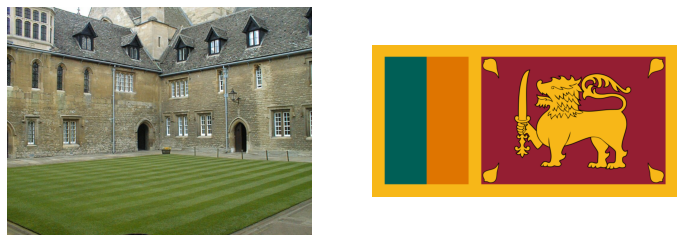

In [45]:
fig,ax=plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img_flag, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [43]:
img_hall.shape

(768, 1024, 3)

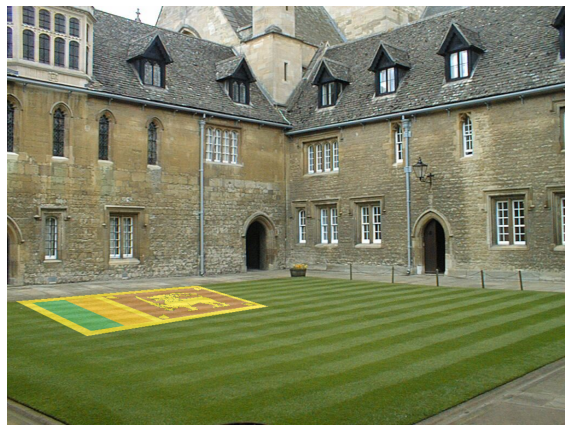

In [46]:
plot_align(img_flag,img_hall)

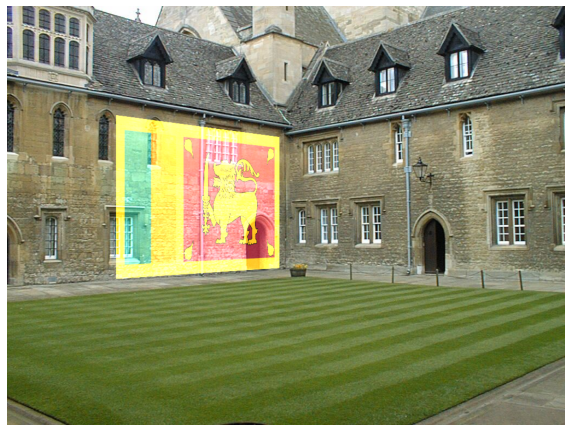

In [34]:
pts_src = np.array([[0, 0], [0, 400], [800, 0],[800, 400]])
pts_dst = np.array([[200, 200], [200,500], [500,240],[500,480]])
h, status = cv.findHomography(pts_src, pts_dst)
im_out = cv.warpPerspective(img_flag, h, (img_hall.shape[1],img_hall.shape[0]))

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(cv.cvtColor(cv.add(img_hall,im_out), cv.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

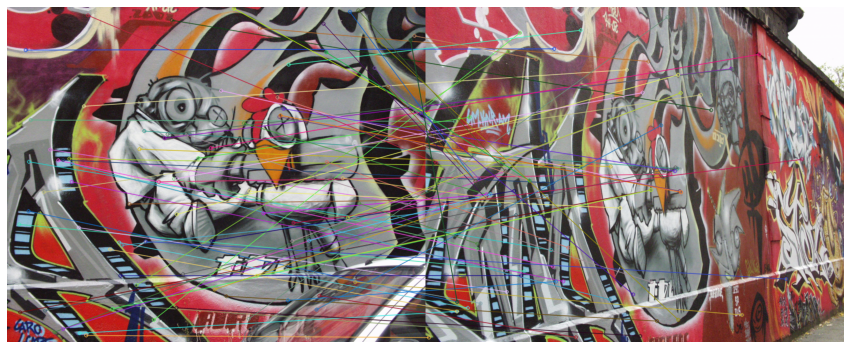

In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

img1=cv.imread(r'graf/img1.ppm')
assert img1 is not None
img5=cv.imread(r'graf/img5.ppm')
assert img5 is not None

gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()

key_p1, des1 = sift.detectAndCompute(gray1,None)
key_p5, des5 = sift.detectAndCompute(gray5,None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des5,k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

img_new = cv.drawMatchesKnn(img1,key_p1,img5,key_p5,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig,ax=plt.subplots(1,1,figsize=(15,15))
ax.imshow(cv.cvtColor(img_new,cv.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

In [8]:
src_pts = 0
dst_pts = 0
dst_pts = np.float32([key_p1[m[0].queryIdx].pt for m in good]).reshape(-1, 2)
src_pts = np.float32([key_p5[m[0].trainIdx].pt for m in good]).reshape(-1, 2)


def generateRandom(src_Pts, dest_Pts, N):
    r = np.random.choice(len(src_Pts), N)
    src = [src_Pts[i] for i in r]
    dest = [dest_Pts[i] for i in r]
    return np.asarray(src, dtype=np.float32), np.asarray(dest, dtype=np.float32)


def findH(src, dest, N):
    A = []
    for i in range(N):
        x, y = src[i][0], src[i][1]
        xp, yp = dest[i][0], dest[i][1]
        A.append([x, y, 1, 0, 0, 0, -x * xp, -xp * y, -xp])
        A.append([0, 0, 0, x, y, 1, -yp * x, -yp * y, -yp])
    A = np.asarray(A)
    U, S, Vh = np.linalg.svd(A)
    L = Vh[-1, :] / Vh[-1, -1]
    H = L.reshape(3, 3)
    return H


def ransacHomography(src_Pts, dst_Pts):
    maxI = 0
    maxLSrc = []
    maxLDest = []
    for i in range(70):
        srcP, destP = generateRandom(src_Pts, dst_Pts, 4)
        H = findH(srcP, destP, 4)
        inlines = 0
        linesSrc = []
        lineDest = []
        for p1, p2 in zip(src_Pts, dst_Pts):
            p1U = (np.append(p1, 1)).reshape(3, 1)
            p2e = H.dot(p1U)
            p2e = (p2e / p2e[2])[:2].reshape(1, 2)[0]
            if cv.norm(p2 - p2e) < 10:
                inlines += 1
                linesSrc.append(p1)
                lineDest.append(p2)
        if inlines > maxI:
            maxI = inlines
            maxLSrc = linesSrc.copy()
            maxLSrc = np.asarray(maxLSrc, dtype=np.float32)
            maxLDest = lineDest.copy()
            maxLDest = np.asarray(maxLDest, dtype=np.float32)
    Hf = findH(maxLSrc, maxLDest, maxI)
    return Hf


H = ransacHomography(src_pts, dst_pts)

dst = cv.warpPerspective(img1, H, ((img1.shape[1] + img5.shape[1]), img5.shape[0])) #wraped image

# now paste them together
dst[0:img5.shape[0], 0:img5.shape[1]] = img5
dst[0:img1.shape[0], 0:img1.shape[1]] = img1
dst[0:gray5.shape[0], 0:gray5.shape[1]] = gray5 #stitched image
plt.imshow(dst)
plt.show()

ValueError: could not broadcast input array from shape (640,800) into shape (640,800,3)

In [19]:
gray5.shape

(640, 800)

In [16]:
H

array([[-1.75777588e-02, -2.20163113e-01,  1.08775134e+02],
       [-1.72843953e-01, -5.09720406e-01,  2.95922755e+02],
       [-5.21112625e-04, -1.75806284e-03,  1.00000000e+00]])

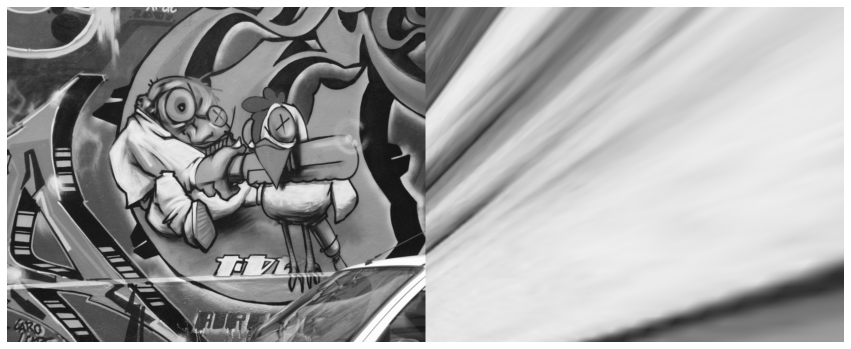

In [33]:
fig,ax=plt.subplots(1,1,figsize=(15,15))
ax.imshow(cv.cvtColor(dst,cv.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

[[ 8.80865731e-01  3.14980996e-01 -4.01531407e+01]
 [-1.82595933e-01  9.36261444e-01  1.53585977e+02]
 [ 1.99108078e-04 -1.76556708e-05  1.00000000e+00]]


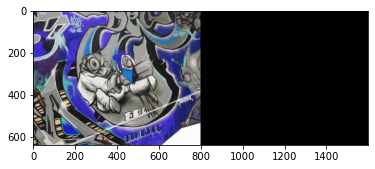

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_1 = cv2.imread('graf/img1.ppm')
img_2 = cv2.imread('graf/img2.ppm')

img1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

good = []
for m in matches:
    if (m[0].distance < 0.85*m[1].distance):
        good.append(m)
matches = np.asarray(good)
if (len(matches[:,0]) >= 4):
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    print(H)
else:
    raise AssertionError('Can’t find enough keypoints.')
    
dst = cv2.warpPerspective(img_1,H,((img_1.shape[1] + img_2.shape[1]), img_2.shape[0])) #wraped image
dst[0:img_2.shape[0], 0:img_2.shape[1]] = img_2 #stitched image
plt.imshow(dst)
plt.show()

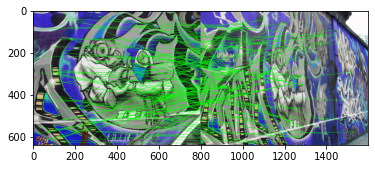

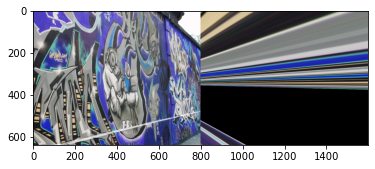

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_ = cv2.imread('graf/img1.ppm')
#img_ = cv2.resize(img_, (0,0), fx=1, fy=1)
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)

img = cv2.imread('graf/img5.ppm')
#img = cv2.resize(img, (0,0), fx=1, fy=1)
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
#cv2.imshow('original_image_left_keypoints',cv2.drawKeypoints(img_,kp1,None))

#FLANN_INDEX_KDTREE = 0
#index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#search_params = dict(checks = 50)
#match = cv2.FlannBasedMatcher(index_params, search_params)
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

img3 = cv2.drawMatches(img_,kp1,img,kp2,good,None,**draw_params)

plt.imshow(img3)
plt.show()
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    #cv2.imshow("original_image_overlapping.jpg", img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

dst = cv2.warpPerspective(img_,M,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0],0:img.shape[1]] = img


def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(dst)
plt.show()

In [1]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
# np . random . seed ( 0 )
N = 100
half_n = N// 2
r = 10
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )
x_=[]
y_=[]
for i in X:
    x_.append(i[0])
    y_.append(i[1])
    

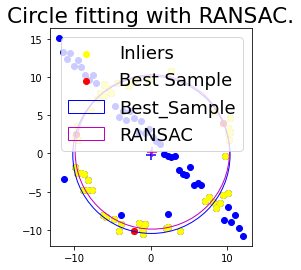

56


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

#Class Object for Generating All required functions for RANSAC 
class RANSAC_gen:
    def __init__(self, x_data, y_data, n):
        self.x_data = x_data
        self.y_data = y_data
        self.n = n
        self.d_max=15
        self.best_model = None
        self.point= None
        self.mod = None
        self.inliers = None
    #Function for Randomly take 3 points sample    
    def random_sampling(self):
        sample = []
        save_ran = []
        count = 0

        # get three points from data
        while True:
            ran = np.random.randint(len(self.x_data))
            if ran not in save_ran:
                sample.append((self.x_data[ran], self.y_data[ran]))
                save_ran.append(ran)
                count += 1

                if count == 3:
                    break

        return sample
    #Function for genarate respective model
    def make_model(self, sample):

        pt1 = sample[0]
        pt2 = sample[1]
        pt3 = sample[2]
       
        A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
        B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
        inv_A = inv(A)

        c_x, c_y = np.dot(inv_A, B) / 2
       
        c_x, c_y = c_x[0], c_y[0]
        r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)
        return c_x, c_y, r
    #Function for filter out inliers
    def get_inliers(self,cx,cy,r):
        P=[]
        t=1.4
        xd=self.x_data
        yd=self.y_data
        for i in range(len(xd)):
            dis = np.sqrt((xd[i]-cx)**2 + (yd[i]-cy)**2)
            if (r-t<=abs(dis)<=r+t):
                P.append([xd[i],yd[i]])
                
        
        return (P)    
    def eval_model(self, model):
        
        c_x, c_y, r = model
        
        P = self.get_inliers(c_x,c_y,r)
        
        return P
    #Find the best model by excuting functions
    def execute_ransac(self):
        # find best model
        
        for i in range(self.n):
            mod=self.random_sampling()
            model = self.make_model(mod)
            c_x, c_y, r = model
            d_temp = self.eval_model(model)
                
            if self.d_max < len(d_temp):
                self.best_model = model
                self.d_max = len(d_temp)
                self.mode = mod
                self.inliers = d_temp
if __name__ == '__main__':
    # make data
    x_data, y_data = x_,y_
    
    plt.scatter(x_data, y_data, c='blue')

    ransac = RANSAC_gen(x_data, y_data, 100)
    
    ransac.execute_ransac()
    
    # get best model sample from ransac
    a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]
    Point = ransac.inliers
    
    x_1=[]
    y_1=[]
    for i in Point:
        x_1.append(i[0])
        y_1.append(i[1])
    
    x_2=[]
    y_2=[]
    for i in ransac.mode:
        x_2.append(i[0])
        y_2.append(i[1])
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.rcParams.update({'font.size': 18})
    plt.scatter(x_1,y_1,color = 'yellow',label='Inliers')
    plt.scatter(x_2,y_2,color = 'red',label='Best Sample')
    plt.scatter(a,b,s = 100,c = 'b',marker = '+')
    circle = plt.Circle((a, b), radius=r, color='b', fc='y', fill=False,label = 'Best_Sample')
    
    plt.gca().add_patch(circle)
    
    
    # get best model from ransac for best sample
    ransac = RANSAC_gen(x_1, y_1, 100)
    ransac.execute_ransac()
    a2, b2, r2 = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]
    circle = plt.Circle((a2, b2), radius=r2, color='m', fc='y', fill=False,label = 'RANSAC')
    plt.scatter(a2,b2,s = 100,c = 'm',marker = '+')
    
    plt.gca().add_patch(circle)
    plt.axis('scaled')
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,3,0,1]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
    plt.title('Circle fitting with RANSAC.')
    plt.show()
    print(len(Point))
    

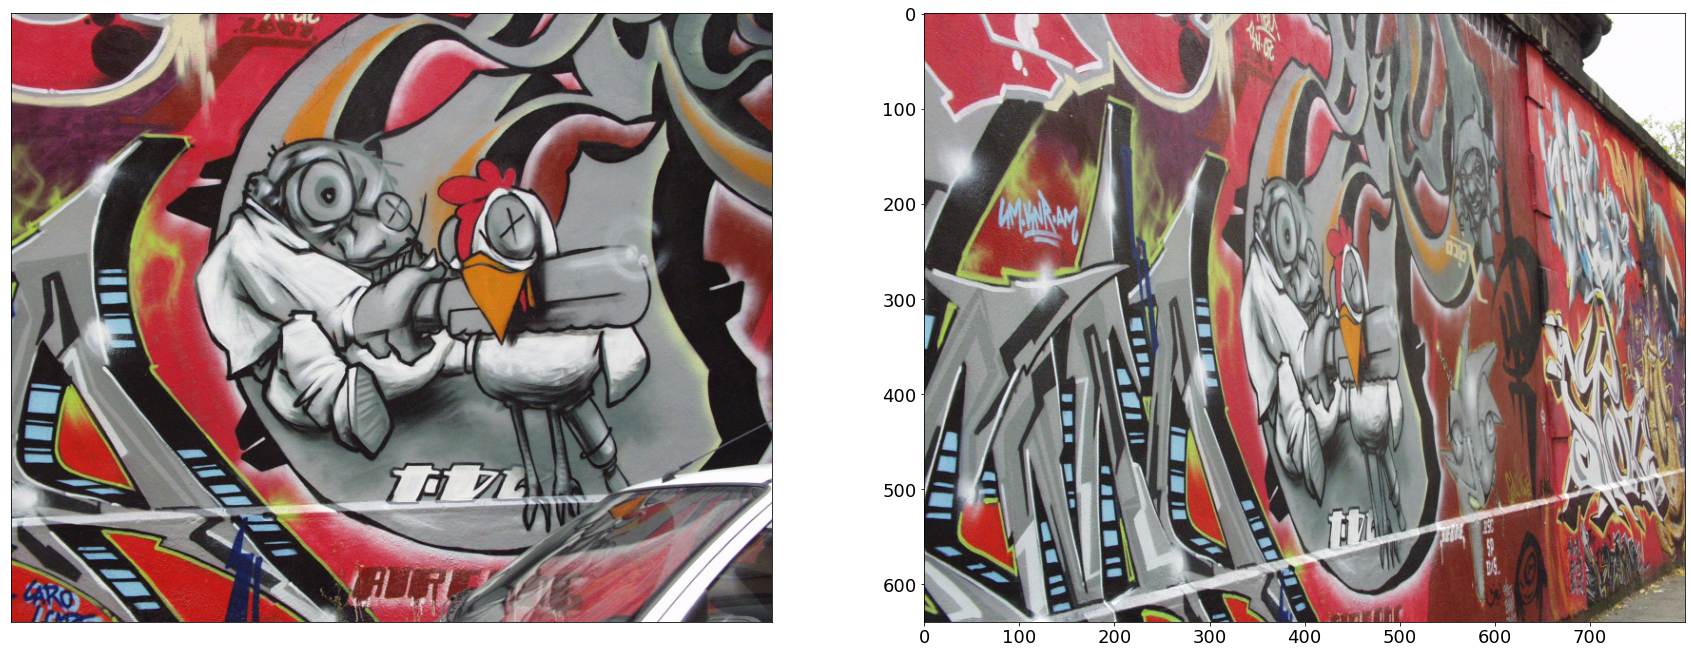

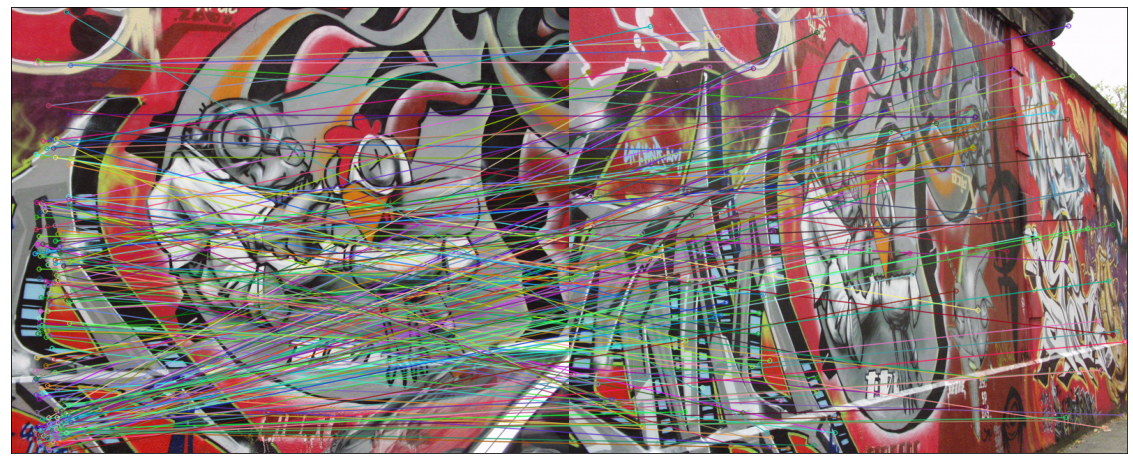

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img1 = cv2.imread('graf/img1.ppm')
img5 = cv2.imread('graf/img5.ppm')
assert img1 is not None
assert img5 is not None

# img5 = img5[:, 200:600, :]

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img5_gray = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.match(des1, des5)
#Matching the keypoints with k-nearest neighbor
match = bf.knnMatch(des1, des5, k=2)

goodMatch = []
#Performing ratio test to find good matches
for m, n in match:
    if m.distance < 0.75*n.distance:
        goodMatch.append(m)

out_img = cv2.drawMatches(img1, key1, img5, key5, matches[100:300], img5, flags=2)

fig, ax = plt.subplots(1, 2, figsize=(30, 15))
ax[0].imshow(img1)
ax[1].imshow(img5)

ax[0].set_xticks([])
ax[0].set_yticks([])

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()


In [11]:
def matched_coordinates(matches, key1, key2):
    p1, p2 = [], []
    for match in matches:
        k1_index = match.queryIdx
        k2_index = match.trainIdx
        point1 = key1[k1_index].pt
        point2 = key2[k2_index].pt
        p1.append(point1)
        p2.append(point2)
    return np.array(p1, dtype=np.float32), np.array(p2, dtype=np.float32)

In [12]:
def inliers(H, points1, points2, thresh_dis):
    count = 0
    inl = []
    for i in range(0, len(matches)):
        B = np.array([[points2[i][0]], [points2[i][1]], [1]])
        A = np.array(H) @ B
        Ax, Ay = A[0][0]/A[-1][0], A[1][0]/A[-1][0]
        Px, Py = points1[i][0], points1[i][1]
        #print(Ax, Ay, Px, Py)
        if (np.sqrt((Ax-Px)**2 + (Ay-Py)**2)<=thresh_dis):
            count += 1          
            inl.append(i)
    return [count-4, inl]

In [17]:
points1, points2 = matched_coordinates(matches, key_p1, key_p5)

H, p, indices = RANSAC_gen(key_p1, key_p5, 2.5)
inliers1, inliers2 = points1[indices], points2[indices]
print(len(inliers1))
img1_h_points, img2_h_points = p[0], p[1] 


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(points1[:, 0], points1[:, 1], 'bo')
ax[0].plot(inliers1[:, 0], inliers1[:, 1], 'yo')
ax[0].plot(img1_h_points[:, 0], img1_h_points[:, 1], 'ro')

ax[1].plot(points2[:, 0], points2[:, 1], 'bo')
ax[1].plot(inliers2[:, 0], inliers2[:, 1], 'yo')
ax[1].plot(img2_h_points[:, 0], img2_h_points[:, 1], 'ro')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img1)
ax[0].plot(img1_h_points[:, 0], img1_h_points[:, 1], 'ro', markersize=5)

ax[1].imshow(img5)
ax[1].plot(img2_h_points[:, 0], img2_h_points[:, 1], 'ro', markersize=5)

plt.show()

TypeError: cannot unpack non-iterable RANSAC_gen object

[[-6.60055326e-01  1.85947830e-02  1.25586047e+02]
 [-1.58909758e+00  4.56641662e-02  3.00167707e+02]
 [-5.47574747e-03  2.63901182e-04  1.00000000e+00]]


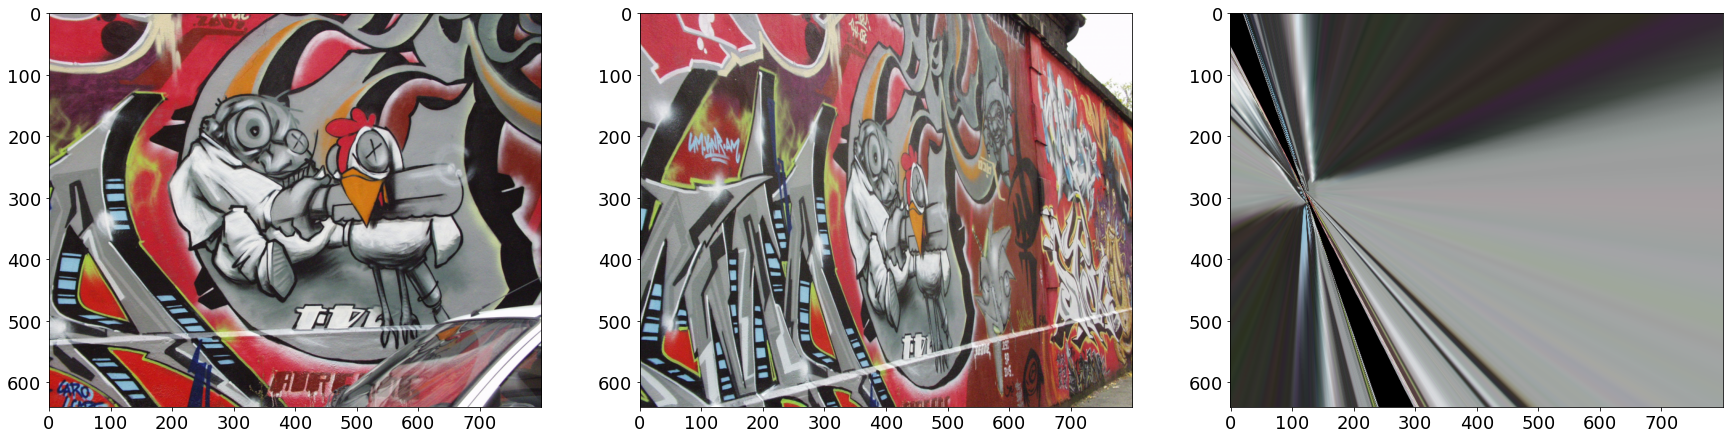

In [18]:
print(H)

out_img = cv2.warpPerspective(img5, np.array(H), (img1.shape[1], img1.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(img1)
ax[1].imshow(img5)
ax[2].imshow(out_img)

plt.show()
